In [1]:
import pandas as pd

file_path = "sp500_historical_data_cleaned.csv"
df = pd.read_csv(file_path)
df.head()


,Date,Close,High,Low,Open,Volume
0,2019-01-02,2510.03,2519.49,2467.47,2476.96,3733160000
1,2019-01-03,2447.89,2493.14,2443.96,2491.92,3858830000
2,2019-01-04,2531.94,2538.07,2474.33,2474.33,4234140000
3,2019-01-07,2549.69,2566.16,2524.56,2535.61,4133120000
4,2019-01-08,2574.41,2579.82,2547.56,2568.11,4120060000


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

df["Date"] = pd.to_datetime(df["Date"])
X = df[["Open", "High", "Low", "Volume"]]
y = df["Close"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2, rmse


(0.9996908215839119, np.float64(15.231020599701255))

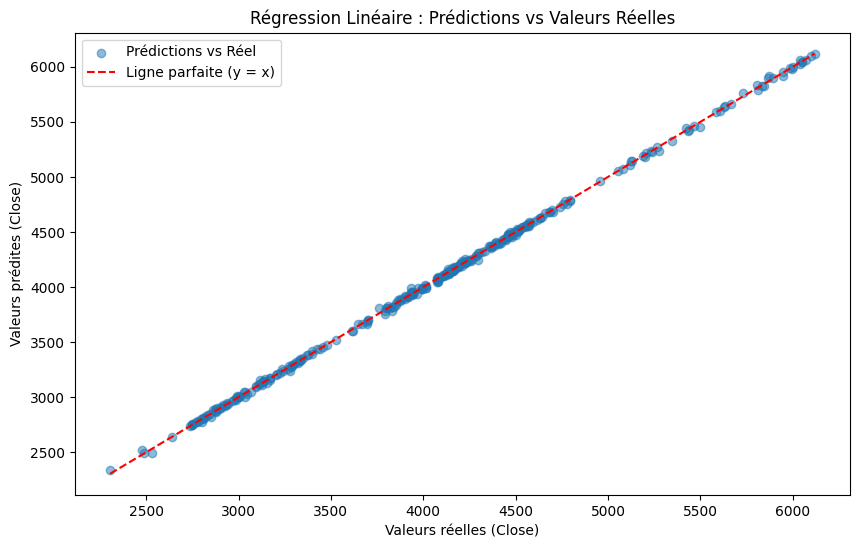

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Prédictions vs Réel")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='dashed', label="Ligne parfaite (y = x)")
plt.xlabel("Valeurs réelles (Close)")
plt.ylabel("Valeurs prédites (Close)")
plt.title("Régression Linéaire : Prédictions vs Valeurs Réelles")
plt.legend()
plt.show()


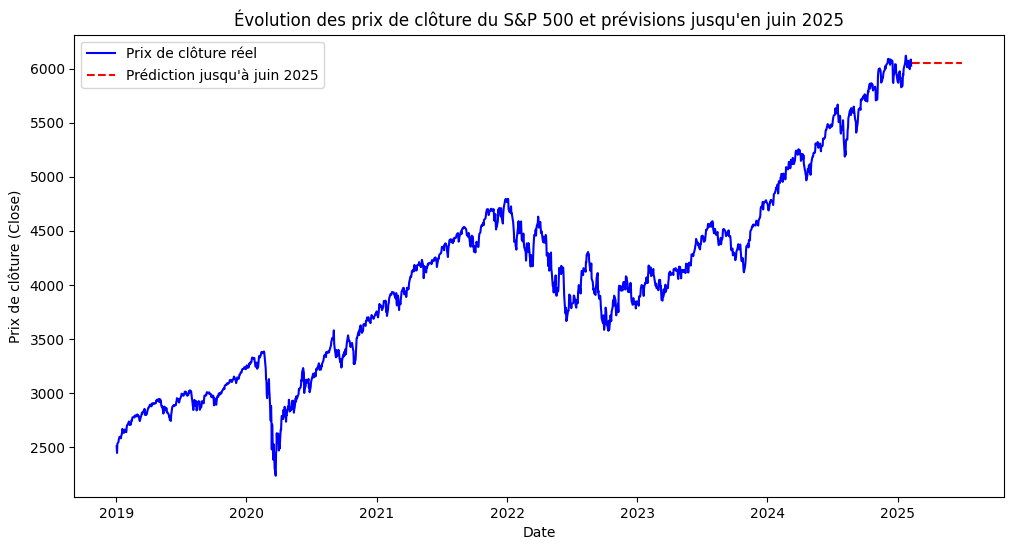

In [4]:

from datetime import datetime, timedelta

df = df.sort_values(by="Date")
future_dates = pd.date_range(start=df["Date"].max() + timedelta(days=1), end="2025-06-30", freq="B")  

future_df = pd.DataFrame(index=future_dates)
future_df["Open"] = df["Open"].iloc[-1]  
future_df["High"] = df["High"].iloc[-1]
future_df["Low"] = df["Low"].iloc[-1]
future_df["Volume"] = df["Volume"].iloc[-1]
future_df["Close_Predicted"] = model.predict(future_df[["Open", "High", "Low", "Volume"]])

plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["Close"], label="Prix de clôture réel", color="blue")
plt.plot(future_df.index, future_df["Close_Predicted"], label="Prédiction jusqu'à juin 2025", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Prix de clôture (Close)")
plt.title("Évolution des prix de clôture du S&P 500 et prévisions jusqu'en juin 2025")
plt.legend()
plt.show()


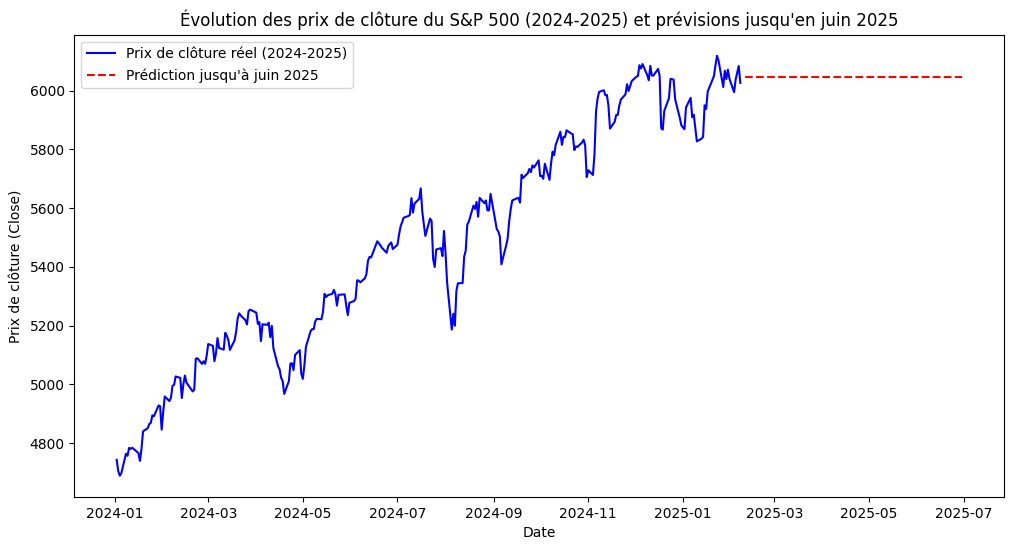

In [5]:
df_recent = df[df["Date"] >= "2024-01-01"]
plt.figure(figsize=(12, 6))
plt.plot(df_recent["Date"], df_recent["Close"], label="Prix de clôture réel (2024-2025)", color="blue")
plt.plot(future_df.index, future_df["Close_Predicted"], label="Prédiction jusqu'à juin 2025", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Prix de clôture (Close)")
plt.title("Évolution des prix de clôture du S&P 500 (2024-2025) et prévisions jusqu'en juin 2025")
plt.legend()
plt.show()


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df = df[:-1]
X_log = df[["Open", "High", "Low", "Volume"]]
y_log = df["Target"]

scaler = StandardScaler()
X_log_scaled = scaler.fit_transform(X_log)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log_scaled, y_log, test_size=0.2, random_state=42)

log_model = LogisticRegression()
log_model.fit(X_train_log, y_train_log)
y_pred_log = log_model.predict(X_test_log)
accuracy = log_model.score(X_test_log, y_test_log)
accuracy


0.5700325732899023

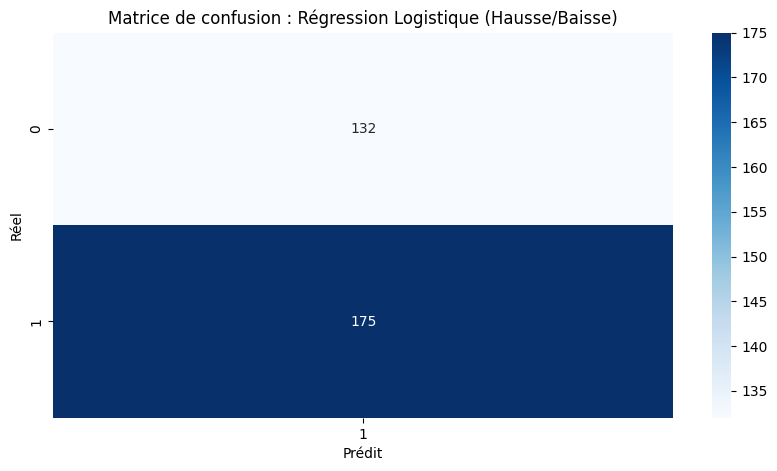

In [7]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.heatmap(pd.crosstab(y_test_log, y_pred_log, rownames=['Réel'], colnames=['Prédit']), annot=True, fmt='d', cmap="Blues")
plt.title("Matrice de confusion : Régression Logistique (Hausse/Baisse)")
plt.show()


In [8]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df["Close"])
adf_statistic = adf_result[0]
p_value = adf_result[1]
adf_statistic, p_value


(np.float64(-0.2539231966115977), np.float64(0.931781414802411))

In [9]:
df["Close_diff"] = df["Close"].diff().dropna()
adf_result_diff = adfuller(df["Close_diff"].dropna())
adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]
adf_statistic_diff, p_value_diff


(np.float64(-12.379369971328671), np.float64(5.0697271438633134e-23))

In [11]:
import pmdarima as pm
model_auto = pm.auto_arima(df["Close"], seasonal=False, stepwise=True, trace=True)
model_auto.order


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject